# [Implementation and application patterns for explaining methods]()
-------
#### Software chapter of the "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning" book 
--------

This is the accompanying code for the software chapter of the book "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning". For a more detailed understanding please have a look into the chapter: [TODO: Add link.]().

-------

### This code snippet only checks the concordance of our code with the original LIME implementation.

--------

Load all modules and initialize the backend.

In [1]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
import imp
import numpy as np
import matplotlib
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', family = 'serif', size=17)
import matplotlib.pyplot as plot
import os
import skimage.segmentation
import sklearn.linear_model
import sklearn.metrics
import tensorflow as tf

import keras
import keras.backend
import keras.layers
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph

from innvestigate.analyzer import ReverseAnalyzerBase
from innvestigate.analyzer.relevance_based import relevance_rule as LRPRules

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source('utils', '../utils.py')
imgnetutils = imp.load_source('utils_imagenet', '../utils_imagenet.py')

# Get session for native TF code
assert keras.backend.backend() == 'tensorflow'
sess = keras.backend.get_session()

Using TensorFlow backend.


Load the VGG16 network and set image conversion parameters.

In [3]:
# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, 'vgg16')
net = tmp(load_weights=True, load_patterns=True)

# Build the model.
model = keras.models.Model(inputs=net['in'], outputs=net['sm_out'])
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == 'channels_first'
if channels_first:
    channel_axis = 1
else:
    channel_axis = 3
color_conversion = 'BGRtoRGB' if net['color_coding'] == 'BGR' else None

# This a convience function to wrap mapping implemented in TF into a Keras layer.
def tf_to_keras_mapping(f):
    
    def wrapper(Xs, Ys, bp_Ys, bp_state):
        def inner_wrapper(tensors):
            X, Y, bp_Y = tensors
            return f(X, Y, bp_Y, bp_state)
        
        X, Y, bp_Y = Xs[0], Ys[0], bp_Ys[0]
        output_shape = keras.backend.int_shape(X)
        return keras.layers.Lambda(inner_wrapper, output_shape=output_shape)([X, Y, bp_Y])
    
    return wrapper

We want to analyze the pre-softmax activations:

In [4]:
# Create model without trailing softmax
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Get TF tensors
input, output = model_wo_sm.inputs[0], model_wo_sm.outputs[0]
# Reduce output to response of neuron with largest activation
max_output = tf.reduce_max(output, axis=1)

Finally, we load also one sample image:

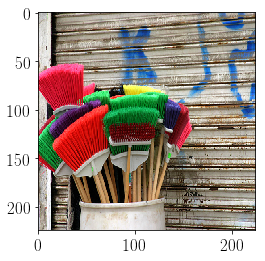

In [5]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net['image_shape'][0])

if not len(images):
    raise Exception('Please download the example images using: '
                    '\'innvestigate/examples/images/wget_imagenet_2011_samples.sh\'')

# Choose a sample image and add batch axis
x_not_pp = images[3][0][None, :, :, :]
# Preprocess it for VGG16
x = imgnetutils.preprocess(x_not_pp, net)
# Displaying the image
plot.imshow(x_not_pp[0]/255)
plot.show()

## Compare LIME implementation with native implementation

LIME visualization


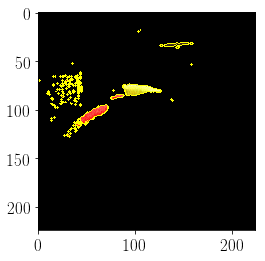

Our heatmap


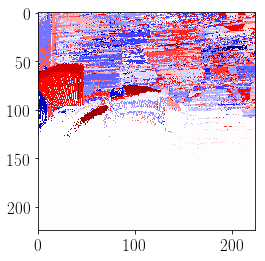

Our regressor with LIME's features


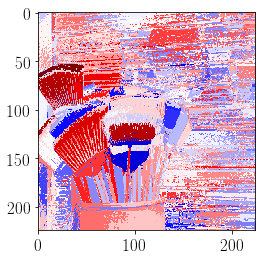

LIME's regressor with LIME's features


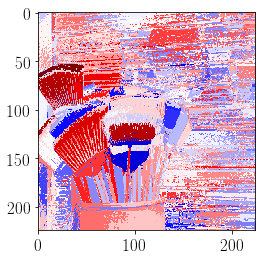

Our label sampling with our regressor.


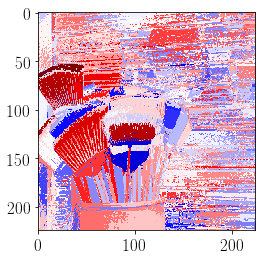

Our label sampling with LIME's regressor


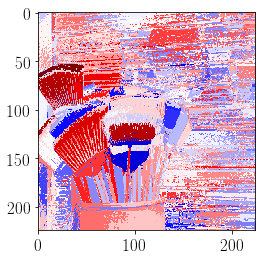

In [8]:
nr_samples = 1000

# Compare with native implementation

# Check how visualization our visualization compares
import lime.lime_image
exp = lime.lime_image.LimeImageExplainer()
def f(x):
    return sess.run(max_output, {input: x}).reshape((-1, 1))

explanation = exp.explain_instance(x[0], f, hide_color=0, num_samples=1000, labels=(0,), top_labels=None)

print("LIME visualization")
tmp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=10, hide_rest=True)
tmp = x_not_pp.copy()[0]
tmp[mask == 0] = 0
plot.imshow(skimage.segmentation.mark_boundaries(tmp/255, mask))
plot.show()

print("Our heatmap")
segment_id_and_weight = explanation.local_exp[0]
segments = explanation.segments

tmp = np.zeros_like(x)
for segment_id, w in segment_id_and_weight:
    tmp[0][segments == segment_id] = (w, w, w)
plot.imshow(imgnetutils.heatmap(tmp)[0])
plot.show()
        
# Check if our label sampling is the same given the same features.
# Segment (not pre-processed) image
segments = skimage.segmentation.quickshift(
    x_not_pp[0], kernel_size=4, max_dist=200, ratio=0.2)
nr_segments = np.max(segments)+1

# Create dataset

# Get lime features
import lime.lime_image
def f(x):
    return sess.run(max_output, {input: x}).reshape((-1, 1))
exp = lime.lime_image.LimeImageExplainer()
features, labels = exp.data_labels(x[0], np.zeros_like(x[0]), segments, f, nr_samples)
labels = np.asarray(labels).reshape((-1,))

# Compute sample weights
distances = sklearn.metrics.pairwise_distances(
            features,
            features[0].reshape(1, -1),
            metric='cosine',
).ravel()
kernel_width = 0.25
sample_weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

# Fit L1-regressor
regressor = sklearn.linear_model.Ridge(alpha=1, fit_intercept=True)
regressor.fit(features, labels, sample_weight=sample_weights)
weights = regressor.coef_

# Map weights onto segments
tmp = np.zeros_like(x)
for segment_id, w in enumerate(weights):
    tmp[0][segments == segment_id] = (w, w, w)


# Postprocess
print("Our regressor with LIME's features")
plot.imshow(imgnetutils.heatmap(tmp)[0])
plot.show()

# Compare with native implementation
import lime.lime_base
def kernel_fn(d):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))
base = lime.lime_base.LimeBase(kernel_fn, False)
(_, weights, _, _) = base.explain_instance_with_data(
                features, np.asarray(labels).reshape((-1, 1)), distances, 0, 1000000)
# Map weights onto segments
tmp = np.zeros_like(x)
for segment_id, w in weights:
    tmp[0][segments == segment_id] = (w, w, w)

# Postprocess
print("LIME's regressor with LIME's features")
plot.imshow(imgnetutils.heatmap(tmp)[0])
plot.show()

# Get labels for features
labels = []
for sample in features:
    tmp = x.copy()
    # Switch segments on and off
    for segment_id, segment_on in enumerate(sample):
        if segment_on == 0:
            tmp[0][segments == segment_id] = (0, 0, 0)
    # Get predicted value for this sample
    labels.append(sess.run(max_output, {input: tmp})[0])

# Compute sample weights
distances = sklearn.metrics.pairwise_distances(
            features,
            features[0].reshape(1, -1),
            metric='cosine',
).ravel()
kernel_width = 0.25
sample_weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

# Fit L1-regressor
regressor = sklearn.linear_model.Ridge(alpha=1, fit_intercept=True)
regressor.fit(features, labels, sample_weight=sample_weights)
weights = regressor.coef_


# Map weights onto segments
tmp = np.zeros_like(x)
for segment_id, w in enumerate(weights):
    tmp[0][segments == segment_id] = (w, w, w)


# Postprocess
print("Our label sampling with our regressor.")
plot.imshow(imgnetutils.heatmap(tmp)[0])
plot.show()

# Compare with native implementation
import lime.lime_base
def kernel_fn(d):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))
base = lime.lime_base.LimeBase(kernel_fn, False)
(_, weights, _, _) = base.explain_instance_with_data(
                features, np.asarray(labels).reshape((-1, 1)), distances, 0, 1000000)
# Map weights onto segments
tmp = np.zeros_like(x)
for segment_id, w in weights:
    tmp[0][segments == segment_id] = (w, w, w)

# Postprocess
print("Our label sampling with LIME's regressor")
plot.imshow(imgnetutils.heatmap(tmp)[0])
plot.show()